# 7. Replicating non-linear activation functions

Neural networks, rather than us telling the model what to learn, we give it the tools to discover patterns in data and it tries to figure out the patterns on its own.

And these tools are linear and non-linear functions.

![Screenshot from 2024-06-27 11-15-00.png](<attachment:Screenshot from 2024-06-27 11-15-00.png>)
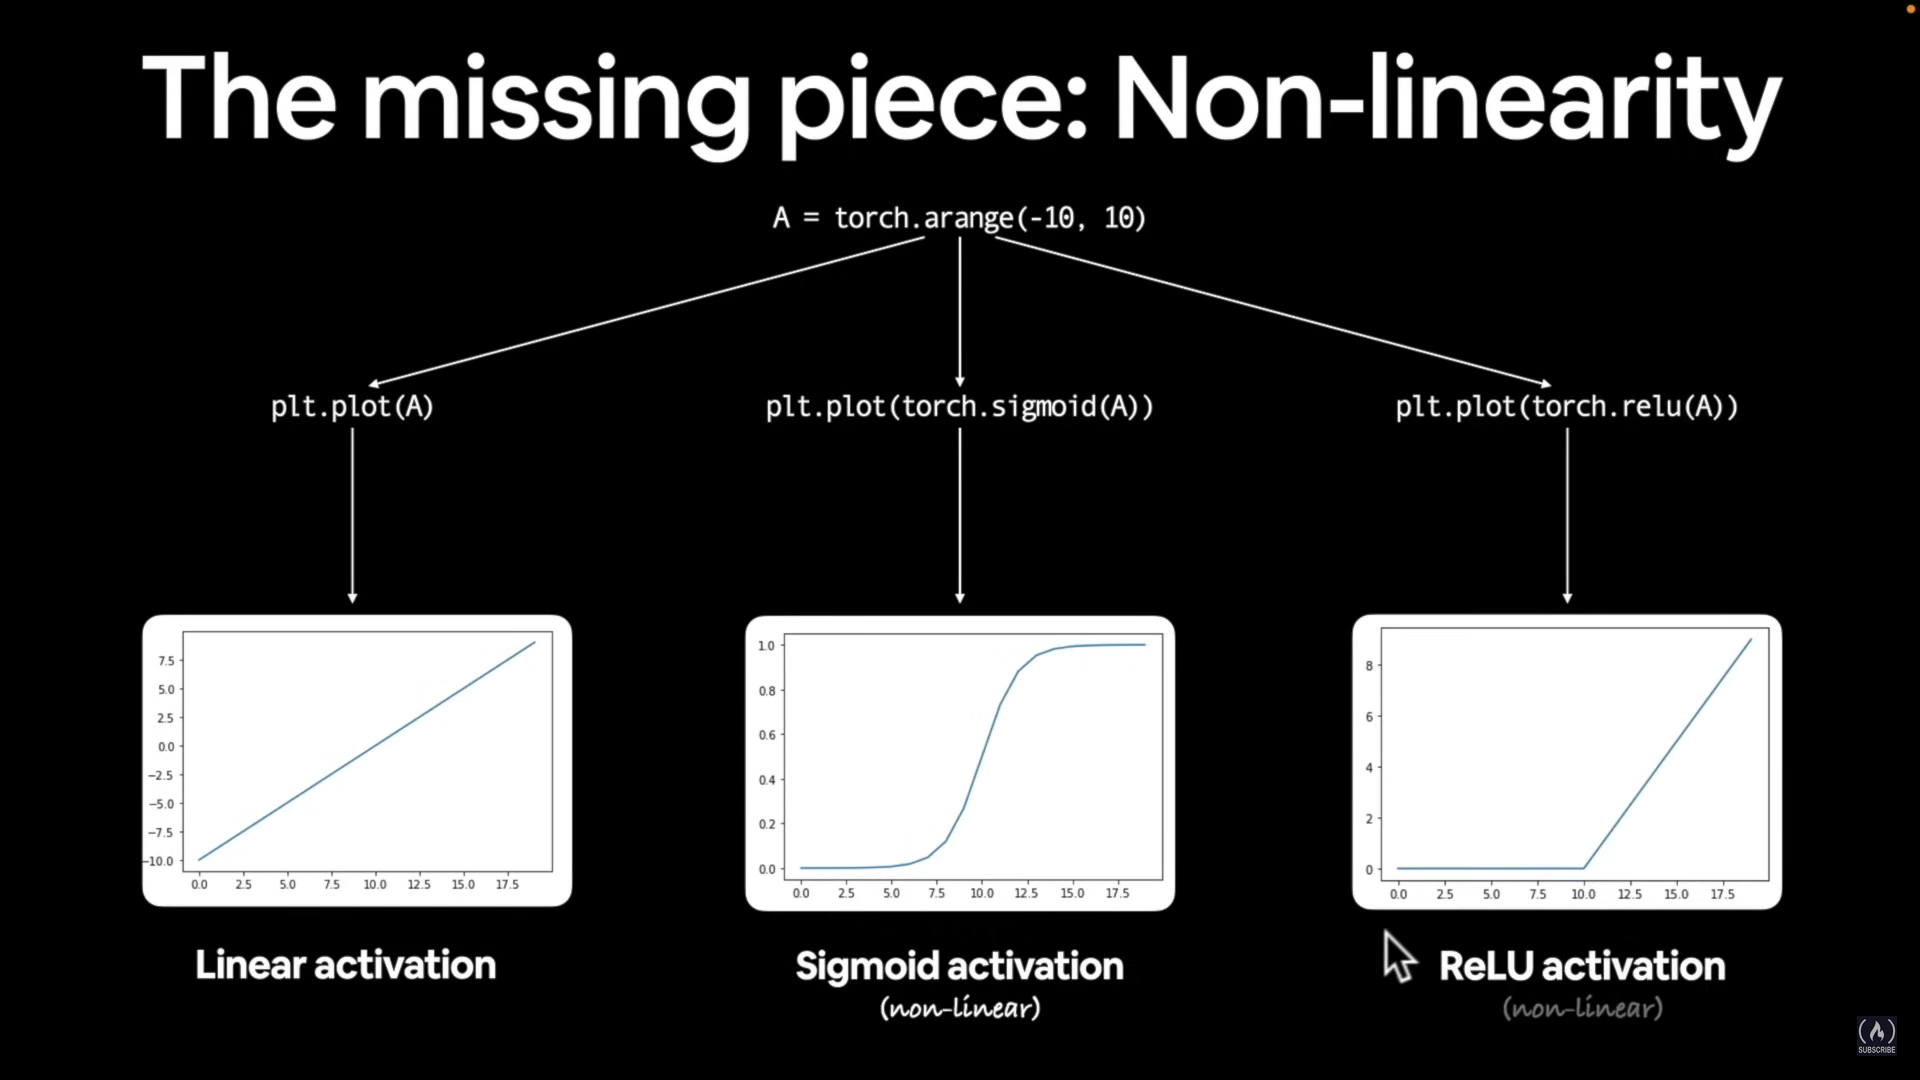

In [3]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from helper_functions import plot_decision_boundary, accuracy_fn, plot_predictions

device = "cuda" if torch.cuda.is_available() else "cpu"

torch.float32


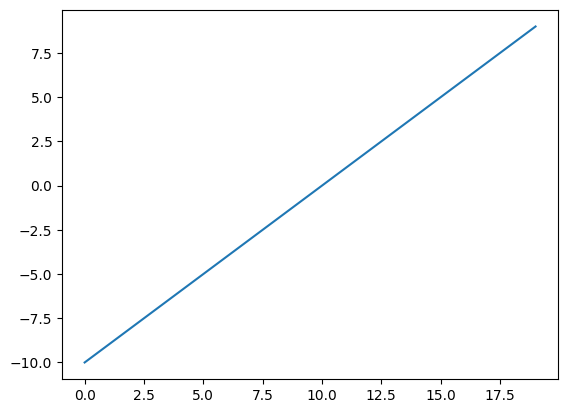

In [4]:
a = torch.arange(-10, 10, 1, dtype=torch.float32)
print(a.dtype)
plt.plot(a)

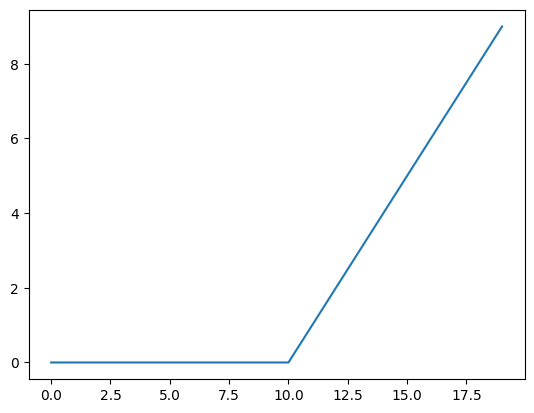

In [5]:
def relu(x: torch.tensor) -> torch.tensor:
    return torch.max(torch.tensor(0), x) # torch.relu(a)

plt.plot(relu(a))

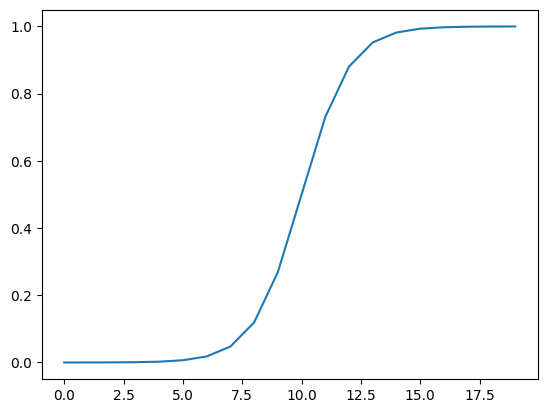

In [6]:
# sigmoid
def sigmoid(x: torch.tensor) -> torch.tensor:
    return 1 / (1 + torch.exp(-x)) # torch.sigmoid(a)

plt.plot(sigmoid(a))

#### 8. Putting it all together with a multi-class classification problem

* binary classification = one thing or another (cat vs dog, spam or not spam, etc)
* multi-class classification = more than one thing or another (rock or paper or scissors, etc)

![Screenshot from 2024-06-27 11-18-08.png](<attachment:Screenshot from 2024-06-27 11-18-08.png>)
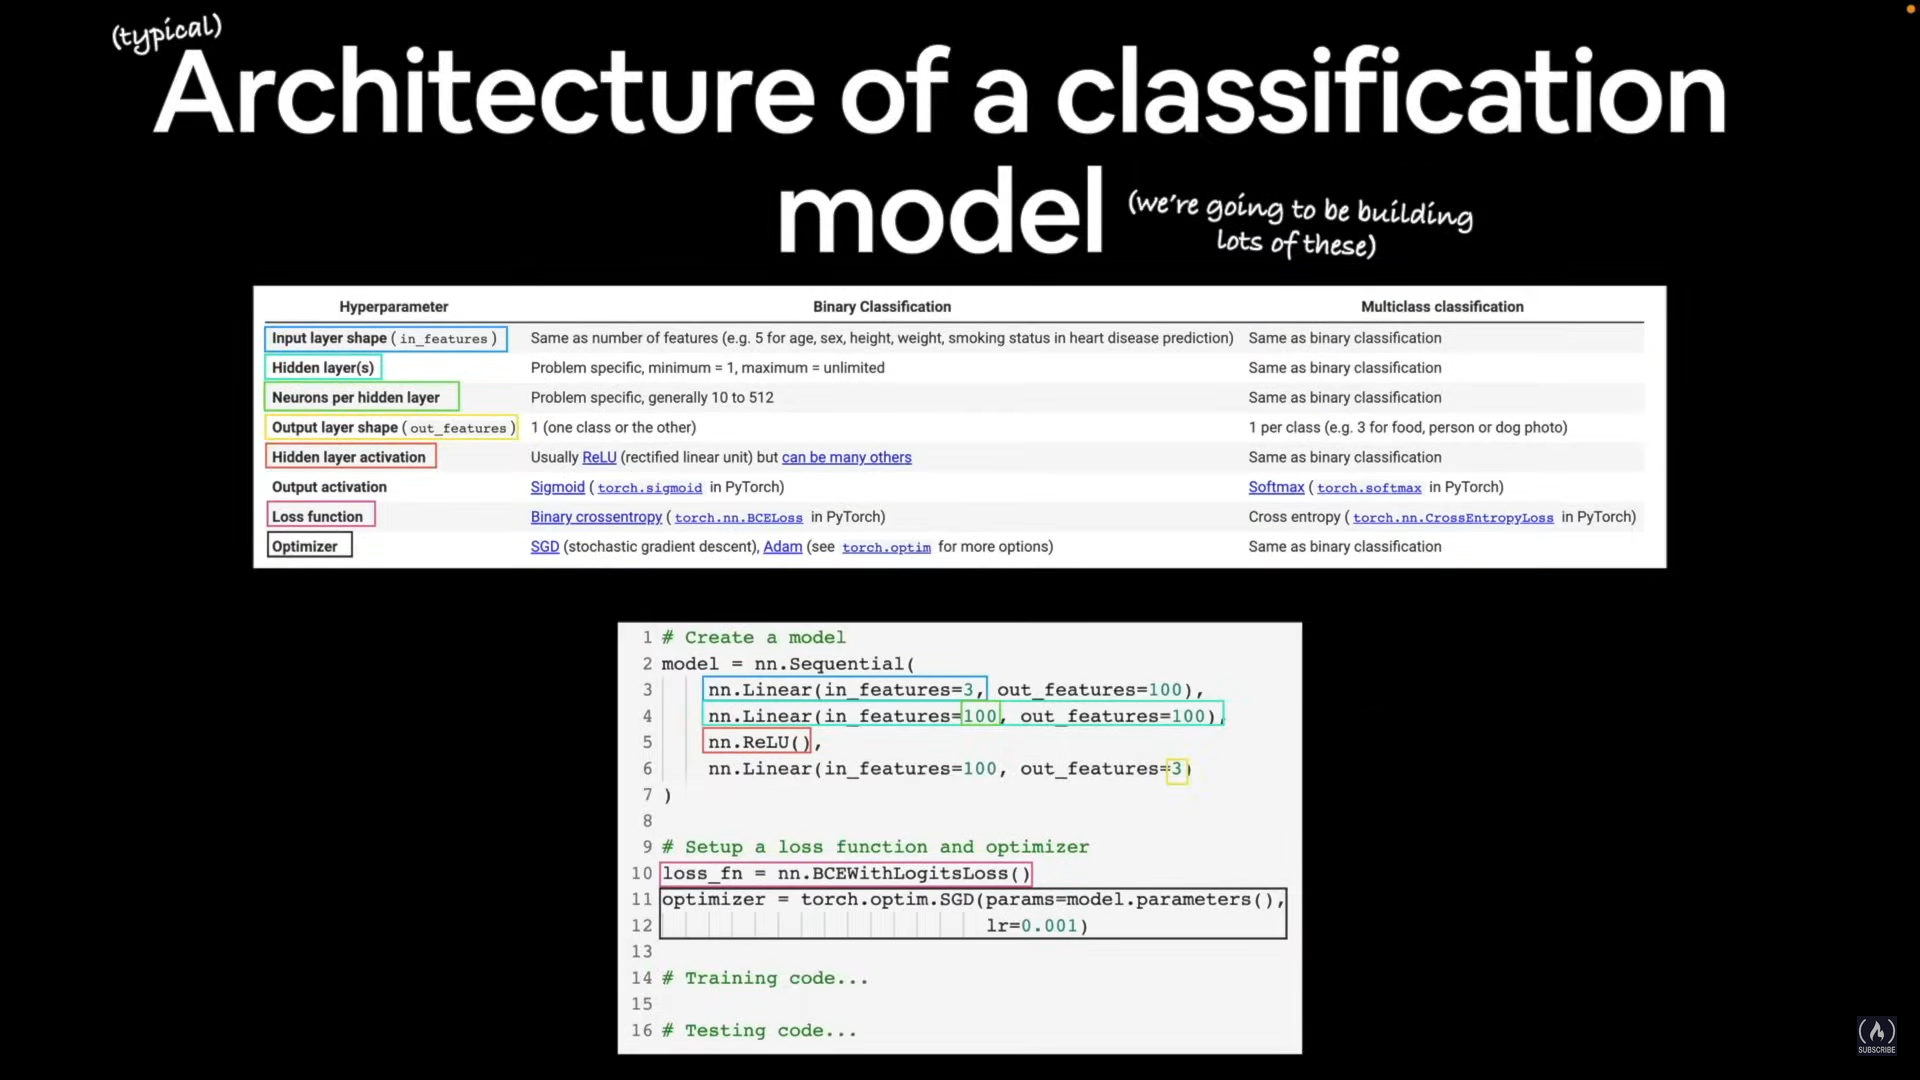

#### 8.1 Creating a toy multi-class dataset

In [7]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

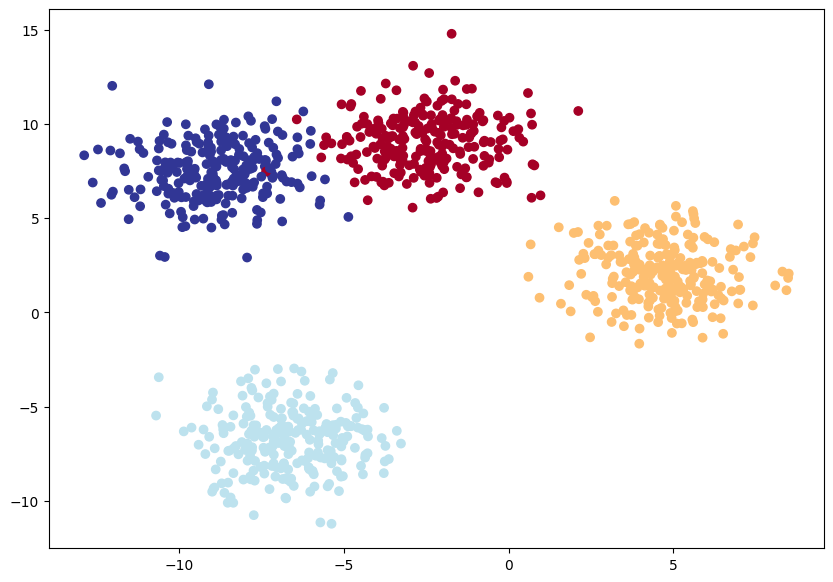

In [8]:
# Set the hyperparameters for data creation

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data

X_blob, y_blob = make_blobs(
    n_samples=1000,
    n_features=NUM_FEATURES, # 2
    centers=NUM_CLASSES, # 4
    cluster_std=1.5, # std (standard deviation): gives the clusters a little shake up
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train and test

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(
    X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)


# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

#### 8.2 Building a multi-class model in PyTorch

In [9]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """
        Initialize multi-class classification model with input, hidden, and output layers.

        Args:
            input_features (int): Number of input features to the model
            output_features (int): Number of output features required
            hidden_units (int, optional): Number of hidden units between layers. Defaults to 8.

        Returns:
            None               
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)
    

In [10]:
print(X_blob_train.shape, y_blob_train[:5])    
print(torch.unique(y_blob_train))

torch.Size([800, 2]) tensor([1, 0, 2, 2, 0])
tensor([0, 1, 2, 3])


In [11]:
model = BlobModel(
    input_features=2,
    output_features=4,
    hidden_units=8
).to(device)

model

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

#### 8.3 Create a loss function and an optimizer for a multi-class classification model

##### Check loss functions on PyTorch docs
more info on https://pytorch.org/docs/stable/nn.html#loss-functions
- for multi-class classification, use `nn.CrossEntropyLoss` **read about it - very important**
- unbalanced dataset means that each blob has **different number of samples**. in this case, you might want to adjust
the `weight` parameter of the loss function (ex: `nn.CrossEntropyLoss(weight=torch.tensor([0.2, 0.2, 0.2, 0.8]))`)


In [12]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

#### 8.4 Getting prediction probabilities for multi-class classification

In order to evaluate and train and test our model, we need to:

1. convert our model's outputs (logits) into prediction probabilities (y_pred)
2. then convert our prediction probabilities (y_pred) into prediction labels (y_label: 1, 2, 3..).

Logits (raw output of the model) -> prediction probabilities (use `torch.Softmax`) -> prediction labels (use `torch.argmax` to get index of max value)

In [13]:
model.eval()
with torch.inference_mode():
    y_logits = model(X_blob_test.to(device))
    
y_logits[:5]

tensor([[ 0.0210,  0.0473,  0.6382, -0.7162],
        [-0.4051,  0.5750,  0.6656, -0.3904],
        [ 0.1728,  0.0322,  0.3805,  0.3514],
        [-0.0923,  0.0062,  0.5045, -0.3818],
        [-0.4555,  0.5751,  0.7954, -0.2605]])

In [14]:
y_blob_test[:5]

tensor([1, 3, 2, 1, 0])

In [15]:
# convert logits -> prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:5]

tensor([[0.2294, 0.2355, 0.4253, 0.1098],
        [0.1316, 0.3508, 0.3840, 0.1336],
        [0.2328, 0.2023, 0.2865, 0.2784],
        [0.2142, 0.2364, 0.3891, 0.1604],
        [0.1175, 0.3293, 0.4104, 0.1428]])

In [17]:
print(y_pred_probs[0])
print(torch.sum(y_pred_probs[0]))

tensor([0.2294, 0.2355, 0.4253, 0.1098])
tensor(1.)


In [19]:
torch.max(y_pred_probs[0])

tensor(0.4253)

In [20]:
torch.argmax(y_pred_probs[0])

tensor(2)

In [21]:
# convert prediction probabilities -> prediction labels
y_pred = torch.argmax(y_pred_probs, dim=1)
print(y_pred)
print(y_blob_test)

tensor([2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2,
        2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2,
        3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
       

#### 8.5 Creating a training and testing loop for multi-class classification

In [22]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    model.train()
    y_logits = model(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model.eval()

    with torch.inference_mode():
        test_logits = model(X_blob_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_blob_test)
        test_accuracy = accuracy_fn(y_true=y_blob_test, y_pred=test_pred)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Accuracy: {test_accuracy:.2f}%")


Epoch: 0 | Loss: 1.71513 | Accuracy: 20.38% | Test Loss: 1.45225 | Test Accuracy: 7.50%
Epoch: 10 | Loss: 0.86481 | Accuracy: 73.62% | Test Loss: 0.81468 | Test Accuracy: 75.00%
Epoch: 20 | Loss: 0.41028 | Accuracy: 96.62% | Test Loss: 0.38247 | Test Accuracy: 97.00%
Epoch: 30 | Loss: 0.18202 | Accuracy: 99.25% | Test Loss: 0.15811 | Test Accuracy: 98.50%
Epoch: 40 | Loss: 0.09557 | Accuracy: 99.25% | Test Loss: 0.08074 | Test Accuracy: 99.50%
Epoch: 50 | Loss: 0.06897 | Accuracy: 99.25% | Test Loss: 0.05634 | Test Accuracy: 99.50%
Epoch: 60 | Loss: 0.05639 | Accuracy: 99.25% | Test Loss: 0.04463 | Test Accuracy: 99.50%
Epoch: 70 | Loss: 0.04901 | Accuracy: 99.25% | Test Loss: 0.03768 | Test Accuracy: 99.50%
Epoch: 80 | Loss: 0.04413 | Accuracy: 99.25% | Test Loss: 0.03309 | Test Accuracy: 99.50%
Epoch: 90 | Loss: 0.04070 | Accuracy: 99.25% | Test Loss: 0.02984 | Test Accuracy: 99.50%


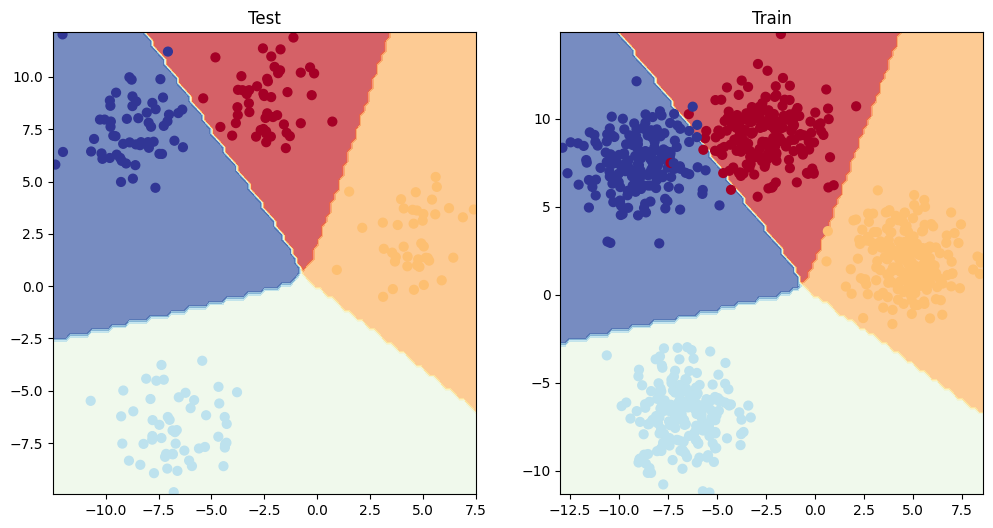

In [29]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Test")
plot_decision_boundary(model, X_blob_test, y_blob_test)

plt.subplot(1, 2, 2)
plt.title("Train")
plot_decision_boundary(model, X_blob_train, y_blob_train)

In [25]:
model.eval()

with torch.inference_mode():
    y_logits = model(X_blob_test)

y_logits[:5]

tensor([[  2.9081,   8.0480,  -3.5416, -11.0317],
        [  5.3668,  -7.4527,  -2.3553,   9.7840],
        [ -0.1027,  -1.2088,   7.0843,  -2.7090],
        [  0.9334,   4.8710,  -1.4667,  -6.5061],
        [  7.3739,   2.9623,  -5.8432,  -4.5808]])

In [26]:
y_pred_probs = torch.softmax(y_logits, dim=1)

y_pred_probs[:5]

tensor([[5.8242e-03, 9.9417e-01, 9.2076e-06, 5.1434e-09],
        [1.1924e-02, 3.2284e-08, 5.2814e-06, 9.8807e-01],
        [7.5553e-04, 2.4996e-04, 9.9894e-01, 5.5765e-05],
        [1.9089e-02, 9.7917e-01, 1.7316e-03, 1.1217e-05],
        [9.8800e-01, 1.1989e-02, 1.7973e-06, 6.3516e-06]])

In [27]:
y_blob_test[:5]

tensor([1, 3, 2, 1, 0])

In [28]:
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:5] 

tensor([1, 3, 2, 1, 0])

#### 9. A few more classification metrics... (to evaluate our classification model)

So far we've only covered a couple of ways of evaluating a classification model (accuracy, loss and visualizing predictions).

These are some of the most common methods you'll come across and are a good starting point.

However, you may want to evaluate your classification model using more metrics such as the following:

| **Metric name/Evaluation method** | **Defintion** | **Code** |
| --- | --- | --- |
| Accuracy | Out of 100 predictions, how many does your model get correct? E.g. 95% accuracy means it gets 95/100 predictions correct. | [`torchmetrics.Accuracy()`](https://torchmetrics.readthedocs.io/en/stable/classification/accuracy.html#id3) or [`sklearn.metrics.accuracy_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) |
| Precision | Proportion of true positives over total number of samples. Higher precision leads to less false positives (model predicts 1 when it should've been 0). | [`torchmetrics.Precision()`](https://torchmetrics.readthedocs.io/en/stable/classification/precision.html#id4) or [`sklearn.metrics.precision_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html) |
| Recall | Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall leads to less false negatives. | [`torchmetrics.Recall()`](https://torchmetrics.readthedocs.io/en/stable/classification/recall.html#id5) or [`sklearn.metrics.recall_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html) |
| F1-score | Combines precision and recall into one metric. 1 is best, 0 is worst. | [`torchmetrics.F1Score()`](https://torchmetrics.readthedocs.io/en/stable/classification/f1_score.html#f1score) or [`sklearn.metrics.f1_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) |
| [Confusion matrix](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/)  | Compares the predicted values with the true values in a tabular way, if 100% correct, all values in the matrix will be top left to bottom right (diagnol line). | [`torchmetrics.ConfusionMatrix`](https://torchmetrics.readthedocs.io/en/stable/classification/confusion_matrix.html#confusionmatrix) or [`sklearn.metrics.plot_confusion_matrix()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay.from_predictions) |
| Classification report | Collection of some of the main classification metrics such as precision, recall and f1-score. | [`sklearn.metrics.classification_report()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) |

Scikit-Learn (a popular and world-class machine learning library) has many implementations of the above metrics and you're looking for a PyTorch-like version, check out [TorchMetrics](https://torchmetrics.readthedocs.io/en/latest/), especially the [TorchMetrics classification section](https://torchmetrics.readthedocs.io/en/stable/pages/classification.html).

#### check out precision recall tradeoff

Let's try the `torchmetrics.Accuracy` metric out.




In [31]:
from torchmetrics import Accuracy

# setup accuracy metric
accuracy_fn = Accuracy(task="multiclass", num_classes=4).to(device)

# calculate accuracy
accuracy_fn(y_preds, y_blob_test)

tensor(0.9950)

In [35]:
class LinearModel(nn.Module):
    def __init__(self, inf: int, outf: int, hidf: int) -> None:
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=inf, out_features=hidf),
            nn.Linear(in_features=hidf, out_features=hidf),
            nn.Linear(in_features=hidf, out_features=outf),
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

model2 = LinearModel(2, 4, 8)
model2  

LinearModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [48]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model2.parameters(), lr=0.01)

epochs = 100

for epoch in range(epochs):
    model2.train()

    y_logits = model2(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1)
    y_label = y_pred.argmax(dim=1)

    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_pred, y_blob_train)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model2.eval()

    with torch.inference_mode():
        test_logits = model2(X_blob_test)
        test_pred = torch.softmax(test_logits, dim=1)
        test_label = torch.argmax(test_pred)

        loss = loss_fn(test_pred, y_blob_test)
        test_acc = accuracy_fn(test_pred, y_blob_test)
        
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Accuracy: {test_accuracy:.2f}%")

Epoch: 0 | Loss: 1.40540 | Accuracy: 0.16% | Test Loss: 0.02763 | Test Accuracy: 99.50%
Epoch: 10 | Loss: 1.23402 | Accuracy: 0.51% | Test Loss: 0.02763 | Test Accuracy: 99.50%
Epoch: 20 | Loss: 1.13681 | Accuracy: 0.72% | Test Loss: 0.02763 | Test Accuracy: 99.50%
Epoch: 30 | Loss: 1.07644 | Accuracy: 0.81% | Test Loss: 0.02763 | Test Accuracy: 99.50%
Epoch: 40 | Loss: 1.03243 | Accuracy: 0.93% | Test Loss: 0.02763 | Test Accuracy: 99.50%
Epoch: 50 | Loss: 0.99659 | Accuracy: 0.96% | Test Loss: 0.02763 | Test Accuracy: 99.50%
Epoch: 60 | Loss: 0.96617 | Accuracy: 0.98% | Test Loss: 0.02763 | Test Accuracy: 99.50%
Epoch: 70 | Loss: 0.94018 | Accuracy: 0.99% | Test Loss: 0.02763 | Test Accuracy: 99.50%
Epoch: 80 | Loss: 0.91806 | Accuracy: 0.99% | Test Loss: 0.02763 | Test Accuracy: 99.50%
Epoch: 90 | Loss: 0.89931 | Accuracy: 0.99% | Test Loss: 0.02763 | Test Accuracy: 99.50%


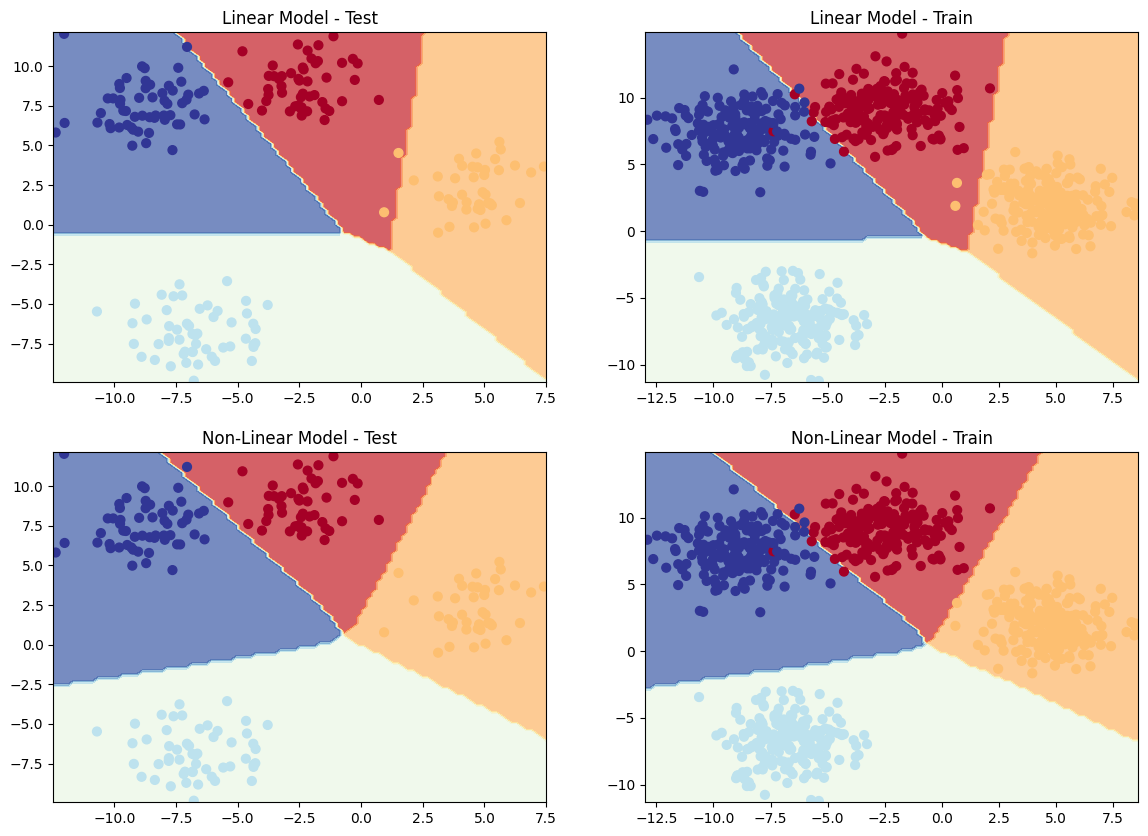

In [61]:
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.title("Linear Model - Test")
plot_decision_boundary(model2, X_blob_test, y_blob_test)

plt.subplot(2, 2, 2)
plt.title("Linear Model - Train")
plot_decision_boundary(model2, X_blob_train, y_blob_train)

plt.subplot(2, 2, 3)
plt.title("Non-Linear Model - Test")
plot_decision_boundary(model, X_blob_test, y_blob_test)

plt.subplot(2, 2, 4)
plt.title("Non-Linear Model - Train")
plot_decision_boundary(model, X_blob_train, y_blob_train)